In [ ]:
!pip3 install jupyterthemes

     |████████████████████████████████| 7.0MB 3.7MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 9.5MB 56.9MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
ERROR: google-colab 1.0.0 has requirement notebook~=5.3.0; python_version >= "3.0", but you'll have notebook 6.1.4 which is incompatible.
  Found existing installation: notebook 5.3.1
    Uninstalling notebook-5.3.1:
      Successfully uninstalled notebook-5.3.1


In [ ]:
!mkdir DATA

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-10-17 13:30:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-17 13:30:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-17 13:30:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/IMDB.csv DATA/

In [ ]:
!mv glove.6B.300d.txt DATA/

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchtext.vocab as ttv
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
from utils import preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
from tqdm.notebook import tqdm
from jupyterthemes import jtplot
import pickle
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [82]:
# Read data
df = pd.read_csv("./DATA/IMDB.csv")
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [83]:
# Check for the missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [84]:
# Check how many unique sentiments are present
df["sentiment"].unique()

array(['positive', 'negative'], dtype=object)

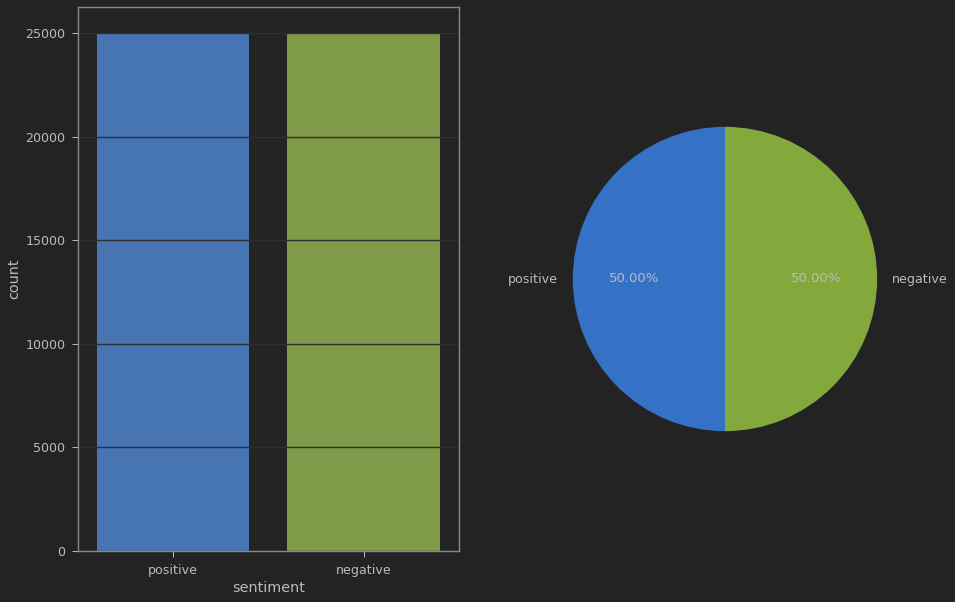

In [85]:
# Check the distribution of classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

sns.countplot(x="sentiment", data=df, ax=ax[0])

count_labels = [len(np.where(df["sentiment"].values == "positive")[0]), len(np.where(df["sentiment"].values=="positive")[0])]

ax[1].pie(count_labels, labels=["positive", "negative"], autopct="%1.2f%%", startangle=90)
plt.show()

In [86]:
# Update the sentiment to integer 
#  0 - negative
# 1 - positive

sentiment = {"negative":0, "positive" : 1}
df["sentiment"] = df["sentiment"].apply(lambda x: sentiment[x])
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [87]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [88]:
review = df["review"].values
new_reviews = []

for text in tqdm(review):
    preprocessed_text = preprocess(text, lemmatize=True)
    new_reviews.append(preprocessed_text[0])
    
print(new_reviews[:2])
    


['one reviewer mention watch oz episode hooked right exactly happen me first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would dare forget pretty picture paint mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watch developed taste oz get accustom high level graphic violence violence injustice crooked guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz may b

In [89]:
df["preprocessed_reviews"] = new_reviews
df.head(5)

,review,sentiment,preprocessed_reviews
0,One of the other reviewers has mentioned that ...,1,one reviewer mention watch oz episode hooked r...
1,A wonderful little production. <br /><br />The...,1,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stun fi...


In [90]:
all_reviews = " ".join(df["preprocessed_reviews"].values.tolist())
all_reviews = all_reviews.split()

count_words = Counter(all_reviews)
total_words = len(all_reviews)
sorted_words = count_words.most_common(total_words)
print(f"Top ten words : {sorted_words[:10]}")

Top ten words : [('movie', 101496), ('film', 94352), ('one', 54004), ('make', 44219), ('like', 43332), ('see', 41243), ('get', 35037), ('well', 30891), ('time', 30469), ('good', 29126)]


In [91]:
word2idx = {word:i+1 for i, (word, count) in enumerate(sorted_words)} # Since 0 is reserved for padding


In [92]:
# Encode the reviews

encoded_review = list()
tokenizer = TreebankWordTokenizer()

for review in tqdm(df["preprocessed_reviews"].values):
    tokens = tokenizer.tokenize(review)
    
    _temp = []
    for t in tokens:
        if t in word2idx:
            _temp.append(word2idx[t])
        else:
            _temp.append(0)
            
    encoded_review.append(_temp)

print(encoded_review[:2])


[[3, 992, 314, 12, 2853, 172, 2751, 105, 490, 173, 407, 31, 37, 2863, 2853, 4572, 12240, 20, 456, 92, 105, 258, 13, 1267, 19, 5584, 4829, 9482, 19, 518, 1651, 986, 577, 291, 456, 3324, 223, 68, 258, 149, 2853, 6733, 30, 12473, 5724, 2209, 460, 43959, 510, 1213, 18679, 389, 4079, 1883, 989, 1866, 1736, 796, 206, 43960, 13474, 191, 3763, 7283, 389, 248, 57697, 3557, 10623, 6218, 1163, 850, 2169, 16462, 210, 3587, 6264, 10624, 7220, 6803, 47, 136, 150, 14, 23, 187, 710, 19, 543, 93, 13, 19, 14, 1420, 631, 95, 244, 1453, 2231, 160, 631, 557, 631, 675, 2853, 637, 98, 31, 172, 53, 118, 2863, 1368, 1937, 26, 23, 1379, 12, 1313, 905, 2853, 7, 8230, 191, 422, 1206, 456, 456, 5368, 6051, 1675, 851, 21021, 4530, 99, 414, 7, 150, 8, 8146, 620, 586, 4530, 90, 989, 4645, 543, 257, 553, 1116, 989, 351, 12, 2853, 109, 170, 3257, 2835, 214, 7, 398, 3502, 341], [296, 51, 239, 2, 1508, 57698, 57699, 1069, 30, 3167, 415, 21022, 188, 1638, 334, 235, 44, 439, 8, 57700, 369, 3558, 7, 57701, 391, 2693, 273, 

In [93]:
# Make the encodings of the same size
sequence_length = 250
features = np.zeros((len(encoded_review), sequence_length))

for i, review in tqdm(enumerate(encoded_review)):
    review_len = len(review)
    
    if (review_len <= sequence_length) :
        pad = list(np.zeros(sequence_length - review_len))
        new = pad + review
        
    else:
        new = review[:sequence_length]
        
    features[i, :] = np.array(new)

print(f"Shape of Features Matrix: {features.shape}")


Shape of Features Matrix: (50000, 250)


In [114]:
X = features
y = df["sentiment"].values

# Split the data into train, val and test set
X_train, temp_x, y_train, temp_y = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(temp_x, temp_y, test_size=0.5)

In [115]:
print(f"Shape of Train Features : {X_train.shape}")
print(f"Shape of Train Labels : {y_train.shape}")
print("-"*20)
print(f"Shape of Validation Features : {X_val.shape}")
print(f"Shape of Validation Labels : {y_val.shape}")
print("-"*20)
print(f"Shape of Test Features : {X_test.shape}")
print(f"Shape of Test Labels : {y_test.shape}")

Shape of Train Features : (35000, 250)
Shape of Train Labels : (35000,)
--------------------
Shape of Validation Features : (7500, 250)
Shape of Validation Labels : (7500,)
--------------------
Shape of Test Features : (7500, 250)
Shape of Test Labels : (7500,)


In [116]:
# Create Tensor Datasets
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float())
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float())
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).long(), torch.from_numpy(y_test).float())

# Create batch iterators
batch_size = 64
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

# PyTorch Model

In [117]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_layers, n_classes, embedding_mat, dropout_rate=0.3):
        
        super(SentimentClassifier, self).__init__()
        self.V = vocab_size
        self.D = embedding_dim
        self.H = n_hidden
        self.L = n_layers
        self.O = n_classes
        
        self.embedding = nn.Embedding(self.V, self.D)
        self.embedding.weight = nn.Parameter(embedding_mat, requires_grad=False)
        self.lstm = nn.LSTM(self.D, self.H, self.L, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Sequential(nn.ReLU(),
                               nn.Linear(self.H*2, 64),
                               nn.ReLU(),
                               nn.Dropout(dropout_rate),
                               nn.Linear(64, 16),
                               nn.ReLU(),
                               nn.Dropout(dropout_rate),
                               nn.Linear(16, self.O),
                               nn.Sigmoid())
        
    def forward(self, X):
        h0, c0 = torch.zeros(self.L, X.size(0), self.H).to(device), torch.zeros(self.L, X.size(0), self.H).to(device)
        
        out = self.embedding(X)
        out, (h,c) = self.lstm(out, (h0, c0))
        avg_pool = torch.mean(out, 1)
        max_pool, _ = torch.max(out, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        out = self.fc(conc)
        return out
    

In [118]:
torch.cuda.empty_cache()

In [119]:
def read_glove(dim=300):
    
    file_name = f"glove.6B.{dim}d.txt"
    
    glove = {}
    
    for lines in tqdm(open(f"./DATA/{file_name}", "r")):
        
        lines = lines.split()
        glove[lines[0]] = np.array(lines[1:]).astype(np.float)
        
        
    return glove

def get_glove_mat(glove, vocab, dim=300):
    
    weights = np.zeros((len(vocab)+1, dim))
    
    for words, i in vocab.items():
        if words in glove:
            weights[i] = glove[words]
        else:
            weights[i] = np.random.normal(size=(dim,))
    
    return weights

In [120]:
vocab_size = len(word2idx) + 1
glove = read_glove()

embedding_mat = get_glove_mat(glove, word2idx)

embedding_mat = torch.from_numpy(embedding_mat.astype(np.float32))

In [121]:
embedding_dim = 300
n_hidden = 128
n_layers = 2
n_classes = 1

model = SentimentClassifier(vocab_size, embedding_dim, n_hidden, n_layers, n_classes, embedding_mat, dropout_rate=0.3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
print(f"Device used :{device}")

SentimentClassifier(
  (embedding): Embedding(125066, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=16, out_features=1, bias=True)
    (8): Sigmoid()
  )
)
Device used :cuda:0


In [122]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [123]:
def batch_gd(model, criterion, optimizer, train_iter, val_iter, epochs=20):
    
    """
    --------------------------------------------------
    Description : Function to calculate batch gradient descent
    
    Parameters :
    @param model -- a pytorch model
    @param criterion -- a pytorch loss function
    @param optimizer -- a pytorch optimizer
    @param train_iter -- a pytorch dataloader representing training data
    @param val_iter -- a pytorch dataloader representing validation data or test data
    @epochs -- an integer representing number of epochs (default=20)
    
    Return :
    @ret train_losses -- the training loss
    @ret val_losses -- the validation loss / test loss
    @ret train_accuracy -- training accuracy
    @ret val_accuracy -- validation accuracy / test accuracy
    --------------------------------------------------
    
    """
    
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    
    train_accuracy = np.zeros(epochs)
    val_accuracy = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        train_loss = []
        train_acc = []
        model.train()
        for inputs, targets in tqdm(train_iter):
            
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Reshape the targets for BCEWithLogitsLoss
            targets = targets.view(-1, 1)
            
            # Zero the gradients of the optimizer
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            # loss = criterion(outputs.view(-1, 1), targets)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track the loss
            train_loss.append(loss.item())
            
            # Calculate the accuracy of the model and track it
            
            predictions = np.round(outputs.cpu().detach().numpy())
            acc = np.mean(targets.cpu().numpy() == predictions)
            
            train_acc.append(acc)
            
        
        val_loss = []
        val_acc = []
        model.eval()
            
        for inputs, targets in tqdm(val_iter):
            
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Reshape the target for BCEWithLogitsLoss
            targets = targets.view(-1, 1)
            
            # Forward pass
            outputs = model(inputs)
            # loss = criterion(outputs.view(-1,1), targets)
            loss = criterion(outputs, targets)
            # Track the loss
            val_loss.append(loss.item())
            
            # Calculate the accuracy and track it
            predictions = np.round(outputs.cpu().detach().numpy())
            acc = np.mean(targets.cpu().numpy() == predictions)
            
            val_acc.append(acc)
            
        train_loss = np.mean(train_loss)
        val_loss = np.mean(val_loss)
        
        train_acc = np.mean(train_acc)
        val_acc = np.mean(val_acc)
        
        train_losses[epoch] = train_loss
        val_losses[epoch] = val_loss
        
        train_accuracy[epoch] = train_acc
        val_accuracy[epoch] = val_acc
        
        print(f"Epoch : {epoch+1}/{epochs} | Train Loss : {train_loss} , Train Acc : {train_acc}| Val Loss : {val_loss}, Val Accuracy: {val_acc}")
        
    
    return train_losses, val_losses, train_accuracy, val_accuracy
    

In [124]:
torch.cuda.empty_cache()

In [125]:
train_losses, val_losses, train_acc, val_acc = batch_gd(model, criterion, optimizer, train_iter, val_iter, epochs=15)


Epoch : 1/15 | Train Loss : 0.5725904702595427 , Train Acc : 0.6984362757900235| Val Loss : 0.4302792354660519, Val Accuracy: 0.809763418079096



Epoch : 2/15 | Train Loss : 0.4206723381766889 , Train Acc : 0.8177192151997911| Val Loss : 0.38965830724623246, Val Accuracy: 0.8295815677966102



Epoch : 3/15 | Train Loss : 0.3914782353140536 , Train Acc : 0.8336094606946983| Val Loss : 0.3644142452690561, Val Accuracy: 0.8424699858757062



Epoch : 4/15 | Train Loss : 0.3646440972357825 , Train Acc : 0.8473899843301124| Val Loss : 0.3566956829469083, Val Accuracy: 0.8479431497175142



Epoch : 5/15 | Train Loss : 0.34922860053383237 , Train Acc : 0.8572938430399581| Val Loss : 0.3460154498027543, Val Accuracy: 0.852489406779661



Epoch : 6/15 | Train Loss : 0.3356874686490465 , Train Acc : 0.8632149386262732| Val Loss : 0.33736730051242697, Val Accuracy: 0.8556232344632769



Epoch : 7/15 | Train Loss : 0.323375226865085 , Train Acc : 0.8685035257247323| Val Loss : 0.3295321627441099, Val Accuracy: 0.8586246468926553



Epoch : 8/15 | Train Loss : 0.3132836395088018 , Train Acc : 0.8748530948028206| Val Loss : 0.32353607325230616, Val Accuracy: 0.860743290960452



Epoch : 9/15 | Train Loss : 0.2998077632140852 , Train Acc : 0.8817209127709584| Val Loss : 0.33993391667382195, Val Accuracy: 0.8471045197740112



Epoch : 10/15 | Train Loss : 0.29393897456214024 , Train Acc : 0.8849283429093758| Val Loss : 0.3286611470630613, Val Accuracy: 0.8613612288135594



Epoch : 11/15 | Train Loss : 0.28154071566173755 , Train Acc : 0.8900781862104988| Val Loss : 0.3195494313613843, Val Accuracy: 0.8659516242937854



Epoch : 12/15 | Train Loss : 0.27232494009096836 , Train Acc : 0.895166819012797| Val Loss : 0.3286625735966836, Val Accuracy: 0.8627736581920904



Epoch : 13/15 | Train Loss : 0.264290613968477 , Train Acc : 0.8984517824497258| Val Loss : 0.3066534513954894, Val Accuracy: 0.8687764830508474



Epoch : 14/15 | Train Loss : 0.252040372837941 , Train Acc : 0.9040260185427004| Val Loss : 0.3425031578389265, Val Accuracy: 0.8608757062146892



Epoch : 15/15 | Train Loss : 0.24771082698209193 , Train Acc : 0.9067437646905196| Val Loss : 0.3344217920833725, Val Accuracy: 0.8650688559322034


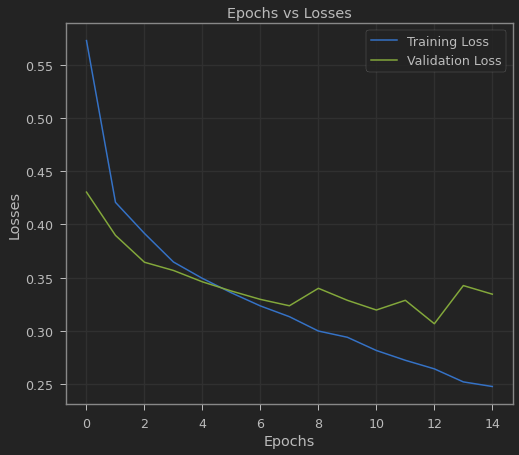

In [126]:
plt.title("Epochs vs Losses")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

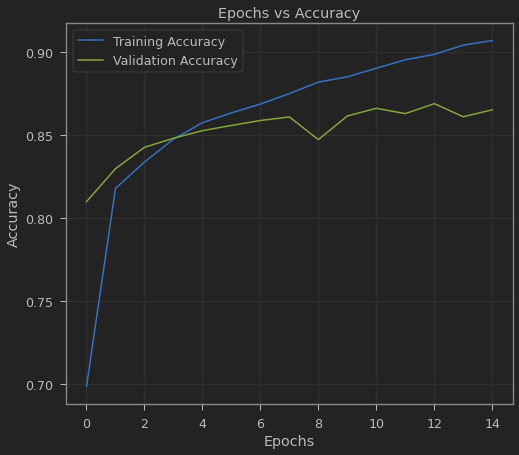

In [127]:
plt.title("Epochs vs Accuracy")
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [128]:
def test_set_grader(mymodel, criterion, test_iter):
    
    test_loss = []
    test_acc = []
    mymodel.eval()
    for inputs, targets in tqdm(test_iter):
        
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.view(-1, 1)
        
        outputs = mymodel(inputs)
        loss = criterion(outputs, targets)
        
        predictions = np.round(outputs.cpu().detach().numpy())
        acc = np.mean(targets.cpu().detach().numpy() == predictions)
        
        test_loss.append(loss.item())
        test_acc.append(acc)
        
    print(f"Test Loss : {np.mean(test_loss)} | Test Acc : {np.mean(test_acc)}")

In [129]:
torch.cuda.empty_cache()

In [130]:
test_set_grader(model, criterion, test_iter)


Test Loss : 0.33868546957522633 | Test Acc : 0.8636


In [131]:
torch.save({"model":model.state_dict(),
            "optimizer":optimizer.state_dict()}, "/content/drive/My Drive/lstm_model.pt")

In [132]:
with open("/content/drive/My Drive/vocabulary.json", "w") as fp:
  json.dump(word2idx, fp)

In [133]:
with open("/content/drive/My Drive/features.npz", "wb") as fp:
  np.save(fp, embedding_mat.numpy())